# Setup
## Load Packages

In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model

import tensorflow as tf

import pandas as pd

import matplotlib.pyplot as plt

import os
import pickle
import numpy as np

Using TensorFlow backend.
/Users/mfansler/miniconda3/envs/aparent-resnet/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mfansler/miniconda3/envs/aparent-resnet/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mfansler/miniconda3/envs/aparent-resnet/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

## Functions

In [2]:
#Function to one-hot encode sequences
def one_hot_encode(seq) :
    
    one_hot = np.zeros((len(seq), 4))
    
    for j in range(len(seq)) :
        if seq[j] == 'A' :
            one_hot[j, 0] = 1.
        elif seq[j] == 'C' :
            one_hot[j, 1] = 1.
        elif seq[j] == 'G' :
            one_hot[j, 2] = 1.
        elif seq[j] == 'T' :
            one_hot[j, 3] = 1.
        elif seq[j] == 'N' :
            one_hot[j, :] = 0.25
    
    return one_hot

## Load APARENT2 Model

In [3]:
model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5_var_batch_size_inference_mode_no_drop'

save_dir = '/Users/mfansler/mayrlab/git/aparent-resnet/saved_models/'
model_path = os.path.join(save_dir, model_name + '.h5')

aparent_model = load_model(model_path)

Instructions for updating:
Colocations handled automatically by placer.


2023-04-10 08:17:03.420497: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
/Users/mfansler/miniconda3/envs/aparent-resnet/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Load Data

In [4]:
df = pd.read_csv("../../data/seq/likely_ip_sites.e30.t5.gc39.w205.csv.gz")

df.head()

,name,seqnames,strand,n_celltypes,seq
0,1:14630:-,chr1,-,1,CACAGGCAGAGGAGGACGAGGACGACTGGGAATCGTAGGGGGCTCC...
1,1:23174:-,chr1,-,1,CAACCCAACCCCTCTAAGCCTCGGTGTTCTCATTTGTGAAGTTGTG...
2,1:24213:-,chr1,-,63,CTAAATAAGCAATAGATGATTAGTTCTTCAATAACAGTTGTGACAA...
3,1:27566:-,chr1,-,1,TTATGATGATTAATTTTGATGCTTAGGTCAGAGTCCATTCTAGGAT...
4,1:101334:+,chr1,+,2,GGAGGCTGAGGCAGGAGAATTCCTTGAACCCAGAAGGTGGAGGTTG...


# Preprocessing

In [5]:
#Create data features

cs_onehots = np.concatenate([one_hot_encode(row['seq'])[None, None, :, :] for _, row in df.iterrows()], axis=0)

#Always set this one-hot variable to 11 (training sub-library bias)
lib = np.zeros((len(df), 13))
lib[:, 11] = 1.

## encoding of "CACAG"
cs_onehots[0,:,:5]

array([[[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.]]])

# Predicting

In [6]:
## Compute cut prediction
_, cs_cut_pred = aparent_model.predict(x=[cs_onehots, lib], batch_size=32, verbose=True)

## Define expected cleavage window
isoform_start = 102 - 15
isoform_end = 102 + 15

cs_iso_pred_narrow = np.sum(cs_cut_pred[:, isoform_start:isoform_end], axis=1)

## Define full window
isoform_start = 0
isoform_end = 205

cs_iso_pred_full = np.sum(cs_cut_pred[:, isoform_start:isoform_end], axis=1)

## extract scores
cs_scores = cs_cut_pred[:, 205]

70462/70462 [==============================] - 555s 8ms/step


In [7]:
cs_iso_pred_narrow[1:10]

array([0.02317773, 0.09231987, 0.31327128, 0.7657312 , 0.65092933,
       0.06828942, 0.11176284, 0.7388023 , 0.9865889 ], dtype=float32)

In [8]:
## Attach statistics
df['likelihood_narrow_w30'] = cs_iso_pred_narrow
df['likelihood_full'] = cs_iso_pred_full
df['score'] = cs_scores

In [9]:
df.head()

,name,seqnames,strand,n_celltypes,seq,likelihood_narrow_w30,likelihood_full,score
0,1:14630:-,chr1,-,1,CACAGGCAGAGGAGGACGAGGACGACTGGGAATCGTAGGGGGCTCC...,0.000546,0.005363,0.994637
1,1:23174:-,chr1,-,1,CAACCCAACCCCTCTAAGCCTCGGTGTTCTCATTTGTGAAGTTGTG...,0.023178,0.074559,0.925441
2,1:24213:-,chr1,-,63,CTAAATAAGCAATAGATGATTAGTTCTTCAATAACAGTTGTGACAA...,0.092320,0.115507,0.884493
3,1:27566:-,chr1,-,1,TTATGATGATTAATTTTGATGCTTAGGTCAGAGTCCATTCTAGGAT...,0.313271,0.420851,0.579149
4,1:101334:+,chr1,+,2,GGAGGCTGAGGCAGGAGAATTCCTTGAACCCAGAAGGTGGAGGTTG...,0.765731,0.821243,0.178757


# Export

In [10]:
df.to_csv("../../data/aparent2/likely_ip_sites.e30.t5.gc39.w205.l11.csv.gz", index=False)

# Exploratory Plots

We already have motif-level evidence that sites in GENCODE without any HCL cell types supporting those sites appear to be of low quality. Here, we'll plot some of the APARENT2 statistics against the number of supporting cell types.

### Likelihood 30 nts around expected site (all)

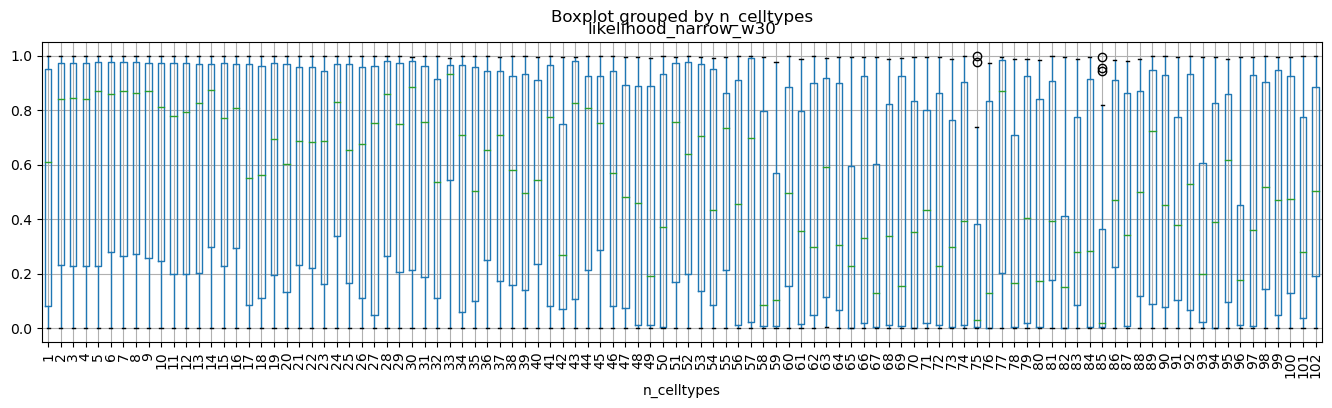

In [11]:
df.boxplot("likelihood_narrow_w30", by="n_celltypes", figsize=(16,4))
plt.xticks(rotation=90)
plt.show()

### Score (all)

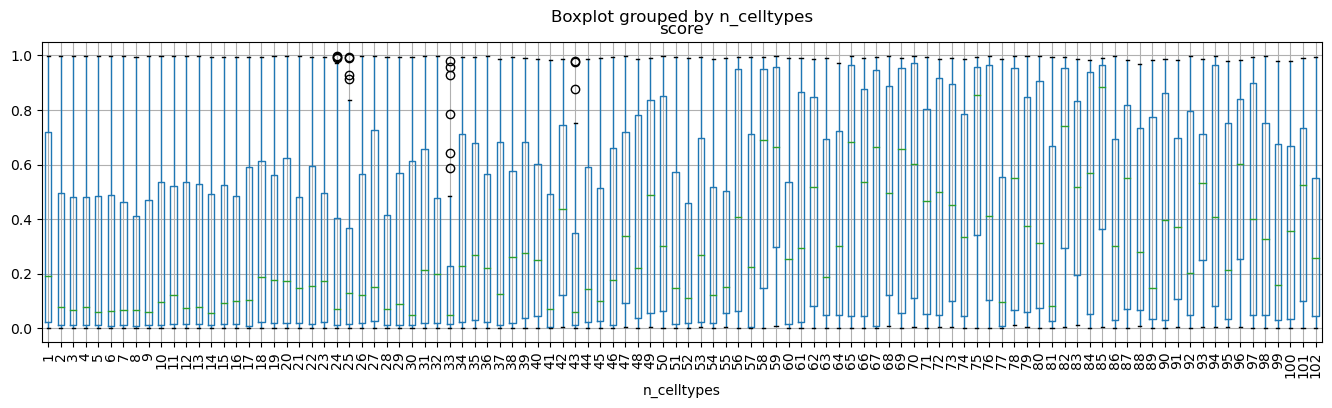

In [12]:
df.boxplot("score", by="n_celltypes", figsize=(16,4))
plt.xticks(rotation=90)
plt.show()

## Control Plots
Strand and chromosome should not be significant factors for APA.

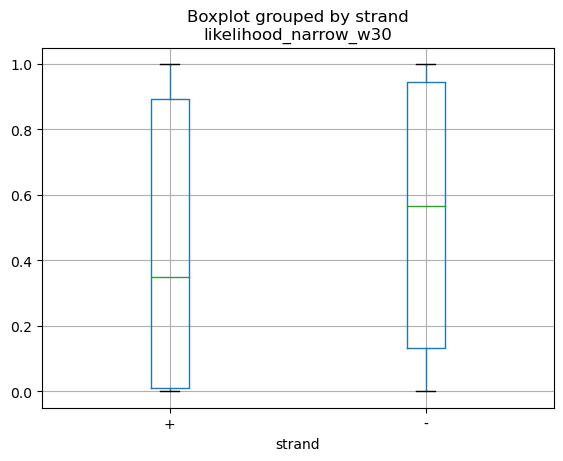

In [13]:
df[df.n_celltypes > 30].boxplot("likelihood_narrow_w30", by="strand")
plt.show()

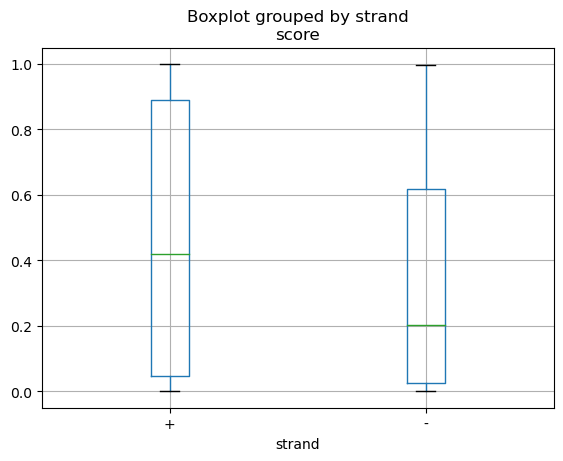

In [14]:
df[df.n_celltypes > 30].boxplot("score", by="strand")
plt.show()

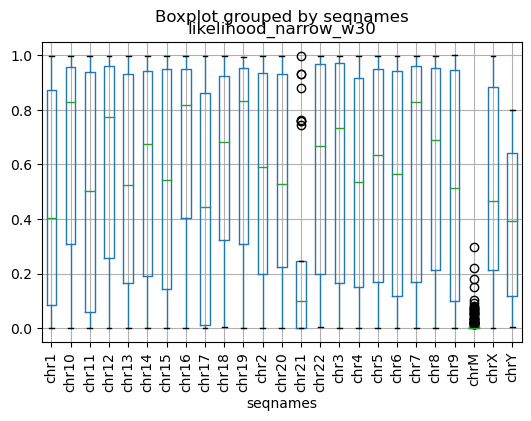

In [15]:
df[df.n_celltypes > 30].boxplot("likelihood_narrow_w30", by="seqnames", figsize=(6,4))
plt.xticks(rotation=90)
plt.show()

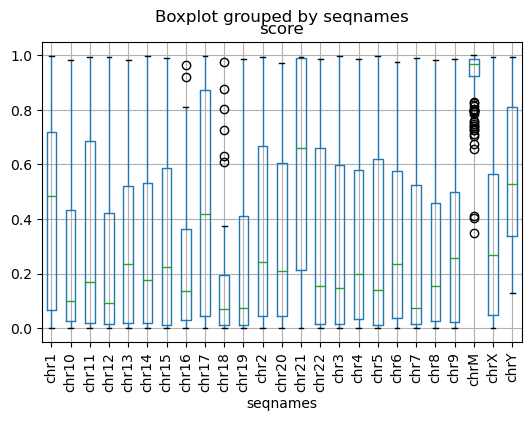

In [16]:
df[df.n_celltypes > 30].boxplot("score", by="seqnames", figsize=(6,4))
plt.xticks(rotation=90)
plt.show()